# <font color = '#e64626'>Assignment 1</font>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopy as geopy
import geocoder
import warnings
warnings.filterwarnings("ignore")
import re

In [130]:
sns.set(style="white")
sns.set_context("notebook",
                rc={"xtick.labelsize": 14,
                    "ytick.labelsize": 14,
                    "axes.labelsize": 15,
                    "axes.titlesize": 20,
                    "legend.fontsize": 13})

# 1. 数据概述

In [3]:
A2B = pd.read_csv("C:/Users/15913/6600/A2B_Fare_Lookup.csv")
A2B.head()

,partitionKey,user_pseudo_id,createdAt,startAddress,endAddress,tripEstimate,BookingID,BookingCreatedTime,PickUp_Latitude,PickUp_Longitude,DropOff_Latitude,DropOff_Longitude,DispatchStatus
0,62988560-2b0f-11ed-aeba-d39c8d7719af,1546E396FBFD49E6ACCB9BCBA42DBFE7,2022-09-03 08:34:19.703,"2 Seaview Ave, Newport NSW 2106, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",126.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51064c10-2cea-11ed-9a00-d5b713a64e81,1546E396FBFD49E6ACCB9BCBA42DBFE7,2022-09-05 17:14:01.170,"181 Lawson St, Darlington NSW 2008, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",30.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,76a63b10-2dcb-11ed-9a00-d5b713a64e81,1546E396FBFD49E6ACCB9BCBA42DBFE7,2022-09-06 20:05:41.060,"17 Millman Rd, Spring Farm NSW 2570, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",158.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5b83c8b9-e7eb-479e-a7fa-4e9c2a110036,1546E396FBFD49E6ACCB9BCBA42DBFE7,2022-10-23 16:41:09.086,"6/73 Albert St, Revesby NSW 2212, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",68.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bb0e3a30-2e95-11ed-9a00-d5b713a64e81,1546E396FBFD49E6ACCB9BCBA42DBFE7,2022-09-07 20:13:34.166,"15 Warrigal St, Gregory Hills NSW 2557, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",160.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
A2B.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1153633 entries, 0 to 1153632
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   partitionKey        1153633 non-null  object 
 1   user_pseudo_id      1153633 non-null  object 
 2   createdAt           1153633 non-null  object 
 3   startAddress        1153415 non-null  object 
 4   endAddress          1153535 non-null  object 
 5   tripEstimate        1153633 non-null  float64
 6   BookingID           521373 non-null   float64
 7   BookingCreatedTime  521373 non-null   object 
 8   PickUp_Latitude     521373 non-null   float64
 9   PickUp_Longitude    521373 non-null   float64
 10  DropOff_Latitude    521371 non-null   float64
 11  DropOff_Longitude   521371 non-null   float64
 12  DispatchStatus      521373 non-null   object 
dtypes: float64(6), object(7)
memory usage: 114.4+ MB


In [5]:
raw = A2B.copy()

In [6]:
raw["DispatchStatus"].value_counts()#查询控制

Completed       340009
NotCompleted    181364
Name: DispatchStatus, dtype: int64

# 2. 质量分析及数据预处理

## 2.1 去重

### 2.1.1 唯一字段去重

In [56]:
# 查看是否有全部重复的记录
raw.duplicated(keep=False).sum()

0

数据集中没有完全重复的记录。  
接下来对一些唯一字段进行查重，判断是否需要处理。
#### partitionKey

In [8]:
raw["partitionKey"].nunique()

1150760

In [9]:
print("{:.2f}% duplicated records in partitionKey.".format(((len(raw) - raw["partitionKey"].nunique()) / len(raw) * 100)))

0.25% duplicated records in partitionKey.


In [6]:
lk_unique=raw["partitionKey"].value_counts()

lk_duplicate=lk_unique[lk_unique>1].index

lk_duplicate_value=lk_unique[lk_unique>1].values

这里是否要可视化？还是直接文字说明就行？

可以关注这2704个重复行为的区（or行程指向）来做一个简单的可视化
--也许可以作为strategy：对于这些反复booking的人，存在

用户预订出租车的流程大致为：  
1. 进入LookUp系统（获得唯一partitionKey）；  
2. 进入Booking系统（获得唯一BookingID）；  
3. 中止预订或完成预订。  

带有重复partitionKey的记录占比并不多，仅有0.25%。  通过观察，带有重复partitionKey的用户，都有多条不重复的BookingID，意味着用户可能在第一次进入booking后，退回了lookup阶段，但并未退出app，而是又发起了第二次booking（甚至第三、四次）。因此，partitionKey理论上也可以存在重复记录。  
然而，以上的情景仅为推测。若按照此逻辑推断，多次booking记录若按时间排序，则应该要么全部是未完成状态，要么只有最新一条记录是完成状态。而数据集中除开这两种情况外，还有其他的情景存在。

In [7]:
raw[raw.duplicated(subset=["partitionKey"], keep=False)].sort_values(by=["partitionKey","BookingCreatedTime"]).head(20)

,partitionKey,user_pseudo_id,createdAt,startAddress,endAddress,tripEstimate,BookingID,BookingCreatedTime,PickUp_Latitude,PickUp_Longitude,DropOff_Latitude,DropOff_Longitude,DispatchStatus
671353,000bafa0-2f6d-11ed-aeba-d39c8d7719af,EEEB8EA50CF946A383580FA06868EA7D,2022-09-08 21:54:31.706,"6 Canyon Rd, Baulkham Hills NSW 2153, Australia","3 Caledonia St, Paddington NSW 2021, Australia",117.50,31506625.0,2022-09-08 21:55:38.846,-33.766901,150.999133,-33.886285,151.232315,Completed
986147,000bafa0-2f6d-11ed-aeba-d39c8d7719af,EEEB8EA50CF946A383580FA06868EA7D,2022-09-08 21:54:31.706,"6 Canyon Rd, Baulkham Hills NSW 2153, Australia","3 Caledonia St, Paddington NSW 2021, Australia",117.50,31506628.0,2022-09-08 21:55:59.770,-33.766901,150.999133,-33.886285,151.232315,NotCompleted
980060,0024cd00-4f16-11ed-8cc4-f1bd638415f1,7B4D91163B174E27925EA76313763DA2,2022-10-19 05:52:22.866,"49-53 Ben Boyd Rd, Neutral Bay NSW 2089, Austr...","ATM 7409, Level 2, Sydney Domestic Airport T2,...",60.90,32437894.0,2022-10-19 05:56:04.786,-33.837923,151.217588,-33.933963,151.180537,NotCompleted
980059,0024cd00-4f16-11ed-8cc4-f1bd638415f1,7B4D91163B174E27925EA76313763DA2,2022-10-19 05:52:22.866,"49-53 Ben Boyd Rd, Neutral Bay NSW 2089, Austr...","ATM 7409, Level 2, Sydney Domestic Airport T2,...",60.90,32437898.0,2022-10-19 05:56:25.120,-33.837923,151.217588,-33.933963,151.180537,NotCompleted
896659,0056add0-4f97-11ed-9661-47dabcf94230,0881df095b1a6de4b06e97be0adc31b5,2022-10-19 21:15:48.270,"72 Park Ave, Kotara NSW 2289, Australia","17 Fowler St, Hamilton South NSW 2303, Australia",18.59,32457847.0,2022-10-19 21:16:07.230,-32.940391,151.711229,-32.935792,151.742417,Completed
1103082,0056add0-4f97-11ed-9661-47dabcf94230,0881df095b1a6de4b06e97be0adc31b5,2022-10-19 21:15:48.270,"72 Park Ave, Kotara NSW 2289, Australia","17 Fowler St, Hamilton South NSW 2303, Australia",18.59,32457850.0,2022-10-19 21:16:15.403,-32.940391,151.711229,-32.935792,151.742417,NotCompleted
1002248,00738720-46f0-11ed-9661-47dabcf94230,19d1af178252c65f698387af9778e32e,2022-10-08 21:00:13.203,"1427 Malvern Rd, Malvern VIC 3144, Australia","49 Luxmoore St, Cheltenham VIC 3192, Australia",46.41,32199112.0,2022-10-08 21:00:26.580,-37.853024,145.041855,-37.959602,145.047761,NotCompleted
710730,00738720-46f0-11ed-9661-47dabcf94230,19d1af178252c65f698387af9778e32e,2022-10-08 21:00:13.203,"1427 Malvern Rd, Malvern VIC 3144, Australia","49 Luxmoore St, Cheltenham VIC 3192, Australia",46.41,32199149.0,2022-10-08 21:02:14.166,-37.853024,145.041855,-37.959602,145.047761,Completed
681402,00934800-484c-11ed-9661-47dabcf94230,6050C2558FC645E7AE9D4CD93599EF28,2022-10-10 14:31:18.273,"25 Ocean View Ave, Airlie Beach QLD 4802, Aust...","1/370 Shute Harbour Rd, Airlie Beach QLD 4802,...",7.77,32234691.0,2022-10-10 14:31:52.346,-20.263768,148.716019,-20.269194,148.718982,Completed
683459,00934800-484c-11ed-9661-47dabcf94230,6050C2558FC645E7AE9D4CD93599EF28,2022-10-10 14:31:18.273,"25 Ocean View Ave, Airlie Beach QLD 4802, Aust...","1/370 Shute Harbour Rd, Airlie Beach QLD 4802,...",7.77,32234736.0,2022-10-10 14:34:00.246,-20.263768,148.716019,-20.269194,148.718982,Completed


In [8]:
partition_duplicated=pd.DataFrame(data=lk_duplicate_value,index=lk_duplicate,columns=['Numbers'])
partition_duplicated
#这里也是创建出现次数

,Numbers
bd3b05c0-51f6-11ed-8cc4-f1bd638415f1,8
18414ee0-584e-11ed-8b11-1f5b62fad19f,5
5fdbdce0-30e2-11ed-9992-2bb9650dd4cf,5
f392dde0-4149-11ed-8cc4-f1bd638415f1,5
d23e2580-2d82-11ed-aeba-d39c8d7719af,5
...,...
d453dfe0-35b6-11ed-9a00-d5b713a64e81,2
253aa540-300a-11ed-9a00-d5b713a64e81,2
72fdece0-3408-11ed-9a00-d5b713a64e81,2
eece6250-3bf6-11ed-9a00-d5b713a64e81,2


通过观察，数据集中patitionKey重复字段可分为以下几种情况：  
* 情况1：全部未完成
* 情况2：只有最后订单完成
* 情况3：超过一个订单完成
* 情况4：一个前序订单完成而其他订单未完成  

情况1&2符合用户的预订流程逻辑，故不做处理。情况3&4，并不符合用户使用app的流程逻辑，推测可能是系统问题导致，因此考虑直接删除对应partitionKey的全部记录。

In [9]:
subset = raw[raw.duplicated(subset=["partitionKey"], keep=False)].sort_values(by=["partitionKey","BookingCreatedTime"])[["partitionKey", "BookingCreatedTime", "DispatchStatus"]]
subset.head(15)

,partitionKey,BookingCreatedTime,DispatchStatus
671353,000bafa0-2f6d-11ed-aeba-d39c8d7719af,2022-09-08 21:55:38.846,Completed
986147,000bafa0-2f6d-11ed-aeba-d39c8d7719af,2022-09-08 21:55:59.770,NotCompleted
980060,0024cd00-4f16-11ed-8cc4-f1bd638415f1,2022-10-19 05:56:04.786,NotCompleted
980059,0024cd00-4f16-11ed-8cc4-f1bd638415f1,2022-10-19 05:56:25.120,NotCompleted
896659,0056add0-4f97-11ed-9661-47dabcf94230,2022-10-19 21:16:07.230,Completed
1103082,0056add0-4f97-11ed-9661-47dabcf94230,2022-10-19 21:16:15.403,NotCompleted
1002248,00738720-46f0-11ed-9661-47dabcf94230,2022-10-08 21:00:26.580,NotCompleted
710730,00738720-46f0-11ed-9661-47dabcf94230,2022-10-08 21:02:14.166,Completed
681402,00934800-484c-11ed-9661-47dabcf94230,2022-10-10 14:31:52.346,Completed
683459,00934800-484c-11ed-9661-47dabcf94230,2022-10-10 14:34:00.246,Completed


直接算哪种情况（对哦 这个个人作业不要求交代码，只要汇报就行了）

In [10]:
for key in partition_duplicated.index:
    temp = subset[subset["partitionKey"] == key]
    if len(temp) - temp["DispatchStatus"].str.contains("NotCompleted").sum() == 0:  # 情景1...
        # 相减是吧！一共多少条重复-没完成的，如果是0，说明全都是没完成的
        partition_duplicated.loc[key, "Scenario"] = 1
    elif len(temp) - temp["DispatchStatus"].str.contains("NotCompleted").sum() == 1 and temp["DispatchStatus"].values[-1] == "Completed":  # 情景2
        partition_duplicated.loc[key, "Scenario"] = 2
    elif len(temp) - temp["DispatchStatus"].str.contains("NotCompleted").sum() > 1:  # 情景3
        partition_duplicated.loc[key, "Scenario"] = 3
    elif temp["DispatchStatus"].values[-1] == "NotCompleted" and len(temp) - temp["DispatchStatus"].str.contains("NotComplete").sum() != 0:  # 情景4
        partition_duplicated.loc[key, "Scenario"] = 4

In [11]:
len(partition_duplicated) - partition_duplicated["Scenario"].notnull().sum()#check有没有问题用的

0

In [12]:
partition_duplicated["Scenario"].value_counts().sort_index()

1.0    1028
2.0     946
3.0     200
4.0     530
Name: Scenario, dtype: int64

In [13]:
partition_duplicated

,Numbers,Scenario
bd3b05c0-51f6-11ed-8cc4-f1bd638415f1,8,1.0
18414ee0-584e-11ed-8b11-1f5b62fad19f,5,1.0
5fdbdce0-30e2-11ed-9992-2bb9650dd4cf,5,4.0
f392dde0-4149-11ed-8cc4-f1bd638415f1,5,4.0
d23e2580-2d82-11ed-aeba-d39c8d7719af,5,2.0
...,...,...
d453dfe0-35b6-11ed-9a00-d5b713a64e81,2,2.0
253aa540-300a-11ed-9a00-d5b713a64e81,2,4.0
72fdece0-3408-11ed-9a00-d5b713a64e81,2,2.0
eece6250-3bf6-11ed-9a00-d5b713a64e81,2,2.0


存储index（scenario为1 2），之后drop

In [14]:
s1s2_index=partition_duplicated[(partition_duplicated['Scenario']==1) | (partition_duplicated['Scenario']==2)].index

In [15]:
dropindex = raw["partitionKey"].isin(partition_duplicated[(partition_duplicated["Scenario"]==3) | (partition_duplicated["Scenario"]==4)].index.values)
raw = raw[~dropindex]#取反，提取不符合条件的值

#### BookingID
BookingID没有任何重复记录。

In [16]:
bks = raw[raw["BookingID"].notnull()]
len(bks)  == bks["BookingID"].nunique()#查bid不为零的子集的长度，以及bid独特值的个数

True

### 2.1.2 逻辑判断去重
在唯一字段的检验中，我们已经剔除了不符合流程逻辑的partitionKey重复记录，并保留了符合逻辑且反应现实的重复记录。但是基于观察，我们不难发现数据集中还存在一些其他不符合逻辑的重复记录，这些记录通过对单一的唯一字段进行检验无法找出，需要多变量联合筛选。  
具体来说，尽管从全数据集来看，LookUp时间和Booking时间是可以重复的字段。但是对于同一个用户来说，在同一时间进行多次查询或预订显然是不符合逻辑的。因此在此部分中，我们考虑将用户id和两个时间字段进行交叉检验，并对存在逻辑问题的记录进行清理。

#### user_pseudo_id & createdAt
通过筛选，将同一用户、同一时间但却有不重复partitionKey的记录挑选出来，一共24条。显然，同一用户不可能在完全相同的时间里提出多次不同（partitionKey不同）的lookup请求，因此考虑将重复记录删除，保留一条记录。若有booking记录，则保留带有booking的记录。

In [17]:
# 查看同一用户同一时间有LookUp记录的数量

# 选出同一用户同一时间的LookUp记录
temp = raw[raw.duplicated(subset=["user_pseudo_id", "createdAt"], keep=False)].sort_values(by=["user_pseudo_id"])  
# 其中有一部分是重复partitionKey的记录，已在上面完成处理，找出不带有重复partitionKey的记录的key
key = temp["partitionKey"].value_counts()[temp["partitionKey"].value_counts() == 1].index.values  
idx = temp["partitionKey"].isin(key)
temp = temp[idx].sort_values(by=["user_pseudo_id","BookingID"])
# 一共有24条记录

In [24]:
temp

,partitionKey,user_pseudo_id,createdAt,startAddress,endAddress,tripEstimate,BookingID,BookingCreatedTime,PickUp_Latitude,PickUp_Longitude,DropOff_Latitude,DropOff_Longitude,DispatchStatus
302517,1f702ef0-2fe7-11ed-aeba-d39c8d7719af,0295699BB96C4A10B921DC0671C726BE,2022-09-09 12:28:42.973,"Domestic Airport Station, Mascot NSW 2020, Aus...","38 Chesterfield Parade, Bronte NSW 2024, Austr...",41.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
302337,1f702ef0-2fe7-11ed-9a00-d5b713a64e81,0295699BB96C4A10B921DC0671C726BE,2022-09-09 12:28:42.973,"Domestic Airport Station, Mascot NSW 2020, Aus...","38 Chesterfield Parade, Bronte NSW 2024, Austr...",41.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357284,4a73a540-4dac-11ed-9661-47dabcf94230,0E9EDF31EB204423BB9FA63D783FC868,2022-10-17 10:43:09.716,"4 Mesa Link, Baldivis WA 6171, Australia","21 Enterprise Way, Rockingham WA 6168, Australia",37.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357193,4a735720-4dac-11ed-8cc4-f1bd638415f1,0E9EDF31EB204423BB9FA63D783FC868,2022-10-17 10:43:09.716,"4 Mesa Link, Baldivis WA 6171, Australia","21 Enterprise Way, Rockingham WA 6168, Australia",37.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218292,7c906290-421f-11ed-9661-47dabcf94230,2E80FAA2D2854929AE1C2BDB9F108F63,2022-10-02 17:57:31.963,"32 Timbertop Mead, Burleigh Heads QLD 4220, Au...","12 Walton St, Southport QLD 4215, Australia",58.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218491,7c90d7c0-421f-11ed-8cc4-f1bd638415f1,2E80FAA2D2854929AE1C2BDB9F108F63,2022-10-02 17:57:31.963,"32 Timbertop Mead, Burleigh Heads QLD 4220, Au...","12 Walton St, Southport QLD 4215, Australia",58.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318066,6054f7f0-5596-11ed-bafc-eb69a13397eb,5209AF53D3F64097B466EDDB77EB0BEE,2022-10-27 12:26:26.800,"Cnr Sayers Rd &, Forsyth Rd, Williams Landing ...","21 Export Dr, Brooklyn VIC 3012, Australia",42.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
317751,6054f7f3-5596-11ed-bafc-eb69a13397eb,5209AF53D3F64097B466EDDB77EB0BEE,2022-10-27 12:26:26.800,"Cnr Sayers Rd &, Forsyth Rd, Williams Landing ...","21 Export Dr, Brooklyn VIC 3012, Australia",42.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
397344,7315b5d0-3af3-4d74-bc8e-aba9d365a692,7B195F2F25E442D58C755696287370B4,2022-10-26 20:28:54.446,"2 Weeroona Ave, Bendigo VIC 3550, Australia","7 Rathbones Ln, Maiden Gully VIC 3551, Australia",32.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
397462,ff5a0236-c955-40fd-9149-472d2d13a0f4,7B195F2F25E442D58C755696287370B4,2022-10-26 20:28:54.446,"2 Weeroona Ave, Bendigo VIC 3550, Australia","7 Rathbones Ln, Maiden Gully VIC 3551, Australia",32.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
keep = temp.drop_duplicates(subset=["createdAt"], inplace=False, keep="first").index  # 首先选出在数据集里要留下的index
#这个index就是真的index 行号
drop = [idx for idx in temp.index]  # 用for循环把重复集中要剔除的index选出来
for idx in drop:
    if idx in keep:
        drop.remove(idx)
drop

[302337,
 357193,
 218491,
 317751,
 397462,
 466297,
 175468,
 504459,
 446079,
 226258,
 426805,
 591485]

In [19]:
raw.drop(drop, axis=0,inplace=True)

In [20]:
raw.info()#数据确实很小了

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152083 entries, 0 to 1153632
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   partitionKey        1152083 non-null  object 
 1   user_pseudo_id      1152083 non-null  object 
 2   createdAt           1152083 non-null  object 
 3   startAddress        1151865 non-null  object 
 4   endAddress          1151985 non-null  object 
 5   tripEstimate        1152083 non-null  float64
 6   BookingID           519835 non-null   float64
 7   BookingCreatedTime  519835 non-null   object 
 8   PickUp_Latitude     519835 non-null   float64
 9   PickUp_Longitude    519835 non-null   float64
 10  DropOff_Latitude    519833 non-null   float64
 11  DropOff_Longitude   519833 non-null   float64
 12  DispatchStatus      519835 non-null   object 
dtypes: float64(6), object(7)
memory usage: 123.1+ MB


#### user_pseudo_id & BookingCreatedTime
BookingCreatedTime没有不合逻辑的重复值，说明booking子集的数据质量较好。

In [21]:
bks = raw[raw["BookingID"].notnull()]  # 选出booking子集
len(bks[bks.duplicated(subset=["user_pseudo_id", "BookingCreatedTime"], keep=False)].sort_values(by=["user_pseudo_id"]))

0

## 2.2 缺失值处理

首先将数据集分为两个子集：查询集（lk_subset）和预订集（bk_subset）。显然，按照流程逻辑，查询集中BookingID及其后序字段均为NAN，而预订集中所有字段应都有对应的值。

In [25]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152083 entries, 0 to 1153632
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   partitionKey        1152083 non-null  object 
 1   user_pseudo_id      1152083 non-null  object 
 2   createdAt           1152083 non-null  object 
 3   startAddress        1151865 non-null  object 
 4   endAddress          1151985 non-null  object 
 5   tripEstimate        1152083 non-null  float64
 6   BookingID           519835 non-null   float64
 7   BookingCreatedTime  519835 non-null   object 
 8   PickUp_Latitude     519835 non-null   float64
 9   PickUp_Longitude    519835 non-null   float64
 10  DropOff_Latitude    519833 non-null   float64
 11  DropOff_Longitude   519833 non-null   float64
 12  DispatchStatus      519835 non-null   object 
dtypes: float64(6), object(7)
memory usage: 123.1+ MB


In [22]:
bk_subset = raw[raw["BookingID"].notnull()]
lk_subset = raw[raw["BookingID"].isnull()]
len(bk_subset) + len(lk_subset) == len(raw)#说明没有交错的空值

True

### 2.2.1 查询集（LookUp Subset）

In [23]:
lk_subset.isnull().sum()

partitionKey               0
user_pseudo_id             0
createdAt                  0
startAddress             114
endAddress                48
tripEstimate               0
BookingID             632248
BookingCreatedTime    632248
PickUp_Latitude       632248
PickUp_Longitude      632248
DropOff_Latitude      632248
DropOff_Longitude     632248
DispatchStatus        632248
dtype: int64

In [24]:
# 两集元素数量相加和两集并集的元素数量相等，所以起始点缺失和终点缺失互不重合
# 因为这里是长度，比如
'''
10  11
01  10
前者的：2=1+1
后者：2=2+1
完事
'''
len(lk_subset[lk_subset["startAddress"].isnull() | lk_subset["endAddress"].isnull()]) == len(lk_subset[lk_subset["startAddress"].isnull()])+len(lk_subset[lk_subset["endAddress"].isnull()])

True

In [25]:
drop = lk_subset[lk_subset["startAddress"].isnull() | lk_subset["endAddress"].isnull()].index

In [26]:
raw.drop(drop, axis=0, inplace=True)#确实 这种就没办法了 因为起点和终点，在没有booking的时候都不会生成的

In [27]:
raw[raw["BookingID"].isnull()].isnull().sum()#好吧！你小子直接在原表上操作了，然后再提出lk表看搞干净了没

partitionKey               0
user_pseudo_id             0
createdAt                  0
startAddress               0
endAddress                 0
tripEstimate               0
BookingID             632086
BookingCreatedTime    632086
PickUp_Latitude       632086
PickUp_Longitude      632086
DropOff_Latitude      632086
DropOff_Longitude     632086
DispatchStatus        632086
dtype: int64

### 2.2.2 预订集（Booking Subset）

In [28]:
bk_subset.isnull().sum()

partitionKey            0
user_pseudo_id          0
createdAt               0
startAddress          104
endAddress             50
tripEstimate            0
BookingID               0
BookingCreatedTime      0
PickUp_Latitude         0
PickUp_Longitude        0
DropOff_Latitude        2
DropOff_Longitude       2
DispatchStatus          0
dtype: int64

#### startAddress & endAddress
同样地，先看startAddress和endAddress

In [29]:
# 两集元素数量相加和两集并集的元素数量相等，所以起始点缺失和终点缺失互不重合
len(bk_subset[bk_subset["startAddress"].isnull() | bk_subset["endAddress"].isnull()]) == len(bk_subset[bk_subset["startAddress"].isnull()])+len(bk_subset[bk_subset["endAddress"].isnull()])

True

#### 修掉那2个drop off的经纬度空值

其实就是2条记录，转换一下就行

In [30]:
drop_missing=bk_subset[bk_subset['DropOff_Latitude'].isnull() | bk_subset['DropOff_Longitude'].isnull()]
drop_missing

,partitionKey,user_pseudo_id,createdAt,startAddress,endAddress,tripEstimate,BookingID,BookingCreatedTime,PickUp_Latitude,PickUp_Longitude,DropOff_Latitude,DropOff_Longitude,DispatchStatus
866815,b5d2440e-01c6-49c9-a3d3-4c4b96ff219c,5294f665d8dc60866199af8d6668b748,2022-10-27 09:15:40.266,"105 Cape St, Heidelberg VIC 3084, Australia","27 Perth St, Heidelberg West VIC 3081, Australia",19.53,32644086.0,2022-10-27 09:15:46.640,-37.755553,145.066975,NaN,NaN,Completed
943894,8389bde0-3b9d-11ed-9a00-d5b713a64e81,135E9F3B2E7146BC8BEC8DA1BD450F08,2022-09-24 10:12:02.110,"723 State Route 15, Malvern East VIC 3145, Aus...","8 Warner Ave, Ashburton VIC 3147, Australia",14.91,31859589.0,2022-09-24 10:12:13.406,-37.881228,145.090564,NaN,NaN,Completed


In [31]:
drop_missing_index=drop_missing.index

In [32]:
for i in range(len(drop_missing)):
    g=geocoder.arcgis(drop_missing.loc[drop_missing_index[i],'endAddress'])
    raw.loc[drop_missing_index[i],['DropOff_Latitude','DropOff_Longitude']]=g.latlng

In [33]:
raw[raw["BookingID"].notnull()].isnull().sum()

partitionKey            0
user_pseudo_id          0
createdAt               0
startAddress          104
endAddress             50
tripEstimate            0
BookingID               0
BookingCreatedTime      0
PickUp_Latitude         0
PickUp_Longitude        0
DropOff_Latitude        0
DropOff_Longitude       0
DispatchStatus          0
dtype: int64

下面开始修address的空值

In [34]:
bk_subset = raw[raw["BookingID"].notnull()]
address_null_index=bk_subset[bk_subset["startAddress"].isnull() | bk_subset["endAddress"].isnull()].index
address_null_subset=bk_subset[bk_subset["startAddress"].isnull() | bk_subset["endAddress"].isnull()]

In [35]:
address_null_subset[['startAddress','endAddress']]=address_null_subset[['startAddress','endAddress']].astype(str)
address_null_subset

,partitionKey,user_pseudo_id,createdAt,startAddress,endAddress,tripEstimate,BookingID,BookingCreatedTime,PickUp_Latitude,PickUp_Longitude,DropOff_Latitude,DropOff_Longitude,DispatchStatus
632260,d12e4f00-4b85-11ed-8cc4-f1bd638415f1,75A0809F02B74300A6E4A25EA34B3184,2022-10-14 17:02:43.056,"1 Bligh Street, 1 Bligh St, Sydney NSW 2000, A...",nan,45.47,32330837.0,2022-10-14 17:02:51.293,-33.864858,151.210544,-33.931785,151.172876,Completed
647694,c8a60c50-2dd6-11ed-aeba-d39c8d7719af,28DB8ADDD31248CFA49E3DE8B974112F,2022-09-06 21:26:43.093,nan,"front of, Terminal 3, Melbourne Airport VIC 30...",41.16,31461756.0,2022-09-06 21:26:49.650,-37.765488,144.860944,-37.673758,144.838017,Completed
648784,f3ace900-2dd6-11ed-9a00-d5b713a64e81,90DF7B6C80554BF0AA8C43BC08F7672D,2022-09-06 21:27:55.280,nan,"front of, Terminal 3, Melbourne Airport VIC 30...",54.18,31461785.0,2022-09-06 21:28:56.430,-37.777088,144.763537,-37.673758,144.838017,Completed
653849,f092d7c0-2dd6-11ed-9a00-d5b713a64e81,674b5059fb4615c8cb49747775ba4f60,2022-09-06 21:27:50.076,"unit 2/15 Collins St, Preston VIC 3072, Australia",nan,47.99,31461801.0,2022-09-06 21:29:58.930,-37.740758,144.992381,-37.673758,144.838017,Completed
653873,44a781d0-4b87-11ed-8cc4-f1bd638415f1,4307A3ECF9CC41DB825ED2FB74875965,2022-10-14 17:13:06.286,"11 Ebrill St, Jamboree Heights QLD 4074, Austr...",nan,97.13,32331215.0,2022-10-14 17:14:43.353,-27.553789,152.938307,-27.385106,153.119326,Completed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131133,a14f2460-4b87-11ed-8cc4-f1bd638415f1,85C5C1DE872344F6BD2285A4016F2E38,2022-10-14 17:15:41.733,"Yeppoon Central Shopping Centre, 42 Park St, Y...",nan,13.65,32331251.0,2022-10-14 17:15:48.123,-23.132291,150.737332,-23.153907,150.742597,NotCompleted
1140881,47034e20-4b71-11ed-9661-47dabcf94230,1CB193D25B044E86BD3C5CD0554980CC,2022-10-14 14:35:41.313,nan,"31 Boreas Rd, Broadmeadow NSW 2292, Australia",15.33,32326467.0,2022-10-14 14:35:47.600,-32.896240,151.723659,-32.914878,151.733945,NotCompleted
1144312,80af7210-4b72-11ed-9661-47dabcf94230,A2ECD4FE243B4BE9834372535CD4DE79,2022-10-14 14:44:27.570,nan,"Commerce Cl, Cannonvale QLD 4802, Australia",15.12,32326693.0,2022-10-14 14:44:50.416,-20.266962,148.711290,-20.283809,148.684828,NotCompleted
1144498,da6af690-4b85-11ed-8cc4-f1bd638415f1,87188525CE94498488A732BB2717165C,2022-10-14 17:02:58.553,"Kessels Road, Nathan, Mount Gravatt QLD 4111, ...",nan,15.12,32330849.0,2022-10-14 17:03:05.866,-27.537284,153.078299,-27.565641,153.086642,NotCompleted


In [36]:
%%time
for i in range(len(address_null_subset)):
    if (address_null_subset.loc[address_null_index[i],'startAddress'])=='nan':
        g=geocoder.osm(address_null_subset.loc[address_null_index[i],['PickUp_Latitude','PickUp_Longitude']].to_list(),method='reverse')
        raw.loc[address_null_index[i],'startAddress']=g.address
    else:
        g=geocoder.osm(address_null_subset.loc[address_null_index[i],['DropOff_Latitude','DropOff_Longitude']].to_list(),method='reverse')
        raw.loc[address_null_index[i],'endAddress']=g.address

Wall time: 1min 54s


In [37]:
raw[raw["BookingID"].notnull()].isnull().sum()

partitionKey          0
user_pseudo_id        0
createdAt             0
startAddress          0
endAddress            0
tripEstimate          0
BookingID             0
BookingCreatedTime    0
PickUp_Latitude       0
PickUp_Longitude      0
DropOff_Latitude      0
DropOff_Longitude     0
DispatchStatus        0
dtype: int64

In [38]:
A2B[A2B["BookingID"].notnull()]

,partitionKey,user_pseudo_id,createdAt,startAddress,endAddress,tripEstimate,BookingID,BookingCreatedTime,PickUp_Latitude,PickUp_Longitude,DropOff_Latitude,DropOff_Longitude,DispatchStatus
632260,d12e4f00-4b85-11ed-8cc4-f1bd638415f1,75A0809F02B74300A6E4A25EA34B3184,2022-10-14 17:02:43.056,"1 Bligh Street, 1 Bligh St, Sydney NSW 2000, A...",NaN,45.47,32330837.0,2022-10-14 17:02:51.293,-33.864858,151.210544,-33.931785,151.172876,Completed
632261,a9e49930-298a-11ed-aeba-d39c8d7719af,755265FF0B0641E4B21204BCB2969304,2022-09-01 10:11:45.093,"56 Carr St, Coogee NSW 2034, Australia","Sydney Airport, Terminal 1 International, Term...",41.79,31335291.0,2022-09-01 10:12:14.363,-33.922957,151.256643,-33.931785,151.172876,Completed
632262,7e86c340-29d4-11ed-9a00-d5b713a64e81,d46cae32826e4c35dec023f024a315ef,2022-09-01 19:00:15.093,"14 Ulm St, Lane Cove North NSW 2066, Australia","Sydney Airport, Terminal 1 International, Term...",80.75,31346907.0,2022-09-01 19:01:00.376,-33.803078,151.156567,-33.931785,151.172876,Completed
632263,2217e2f0-29df-11ed-9a00-d5b713a64e81,EFB5BE26E2CB4586A274ED6C5368CE23,2022-09-01 20:16:24.480,"30 Illawarra Rd, Marrickville NSW 2204, Australia","Sydney Airport, Terminal 1 International, Term...",26.99,31348075.0,2022-09-01 20:17:05.990,-33.903420,151.162245,-33.931785,151.172876,Completed
632264,08e01b20-2a6d-11ed-9a00-d5b713a64e81,8129974B79B5475D9EAE16F8EFA0B21D,2022-09-02 13:12:10.706,"29B Manning Rd, Double Bay NSW 2028, Australia","Sydney Airport, Terminal 1 International, Term...",56.49,31361432.0,2022-09-02 13:13:07.550,-33.880643,151.244051,-33.931785,151.172876,Completed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153628,58a12f10-4a79-11ed-9661-47dabcf94230,35c594558ca760554a635b700bb0900c,2022-10-13 09:00:55.683,"341 Marrickville Rd, Marrickville NSW 2204, Au...","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",31.71,32293544.0,2022-10-13 09:05:40.326,-33.907613,151.150401,-33.931785,151.172876,NotCompleted
1153629,c238b140-4f1b-11ed-8cc4-f1bd638415f1,82709B25CEDA4E2BB5C9AC9E7DAAAA1E,2022-10-19 06:33:35.956,"18 Mermaid Ave, Maroubra NSW 2035, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",33.81,32438205.0,2022-10-19 06:34:04.043,-33.938004,151.258409,-33.931785,151.172876,NotCompleted
1153630,17048e60-4db4-11ed-9661-47dabcf94230,95824FA56C8A43B087A230A26D1B517A,2022-10-17 11:38:59.400,"48 Brennan La, Newtown NSW 2042, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",28.98,32402992.0,2022-10-17 11:39:06.086,-33.897444,151.179887,-33.931785,151.172876,NotCompleted
1153631,e8849e80-45c6-11ed-9661-47dabcf94230,6235549FC1DA40DAAC117A2735DDFC10,2022-10-07 09:33:32.520,"7 Broome St, Waterloo NSW 2017, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",26.25,32156955.0,2022-10-07 09:33:47.040,-33.898434,151.214153,-33.931785,151.172876,NotCompleted


修完了，目测每天1000限制

至此完成数据清洗工作。

In [39]:
washed = raw.copy()
washed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151921 entries, 0 to 1153632
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   partitionKey        1151921 non-null  object 
 1   user_pseudo_id      1151921 non-null  object 
 2   createdAt           1151921 non-null  object 
 3   startAddress        1151921 non-null  object 
 4   endAddress          1151921 non-null  object 
 5   tripEstimate        1151921 non-null  float64
 6   BookingID           519835 non-null   float64
 7   BookingCreatedTime  519835 non-null   object 
 8   PickUp_Latitude     519835 non-null   float64
 9   PickUp_Longitude    519835 non-null   float64
 10  DropOff_Latitude    519835 non-null   float64
 11  DropOff_Longitude   519835 non-null   float64
 12  DispatchStatus      519835 non-null   object 
dtypes: float64(6), object(7)
memory usage: 123.0+ MB


In [49]:
raw[raw["BookingID"].notnull()].isnull().sum()#booking的子集

partitionKey          0
user_pseudo_id        0
createdAt             0
startAddress          0
endAddress            0
tripEstimate          0
BookingID             0
BookingCreatedTime    0
PickUp_Latitude       0
PickUp_Longitude      0
DropOff_Latitude      0
DropOff_Longitude     0
DispatchStatus        0
dtype: int64

In [50]:
raw[raw["BookingID"].isnull()].isnull().sum()#looking的子集

partitionKey               0
user_pseudo_id             0
createdAt                  0
startAddress               0
endAddress                 0
tripEstimate               0
BookingID             632086
BookingCreatedTime    632086
PickUp_Latitude       632086
PickUp_Longitude      632086
DropOff_Latitude      632086
DropOff_Longitude     632086
DispatchStatus        632086
dtype: int64

# 3.0 特征工程

In [40]:
whole=washed.copy()

In [68]:
'''
先保留，用于code自动生成字典
test=whole['startAddress']

test

split_data=test.str.split(',')

split_data

tt=pd.DataFrame({'State':split_data.apply(lambda x:x[-2])})

len(tt['State'].unique())
'''

In [41]:
%%time
# 起始地点dict
state_dict = {
    "NSW": "NSW",
    "New South Wales": "NSW",
    "QLD": "QLD",
    "Queensland": "QLD",
    "Gold Coast": "QLD",
    "Nelly Bay": "QLD",
    "Shute Harbour": "QLD",
    "Sea World": "QLD",
    "Redland": "QLD",
    "SA": "SA",
    "TAS": "TAS",
    "Tasmania": "TAS",
    "VIC": "VIC",
    "RIVER BOULEVARD RICHMOND": "VIC",
    "William St/Collins": "VIC",
    "Victoria": "VIC",
    "WA": "WA",
    "Western Australia": "WA",
    "ACT": "ACT",
    "NT": "NT",
    "Northern Territory": "NT",
    "Coral": "Coral Sea",
    "Great Barrier": "Coral Sea",
    "South Australia": "SA"
}  # 所有起点位置的州信息匹配字典

for key in state_dict.keys():
    whole.loc[whole["startAddress"].str.contains(key), "StartState"] = state_dict[key]  # 若记录的起点位置包含字典中的某个key，则赋值对应value

Wall time: 16.1 s


In [42]:
%%time
# 下车地点
state_dict = {
    "NSW": "NSW",
    "New South Wales": "NSW",
    "Fitzwilliam St": "NSW",
    "Byron Bay": "NSW",
    "QLD": "QLD",
    "Queensland": "QLD",
    "Gold Coast": "QLD",
    "Terminal, Bilinga": "QLD",
    "Tea Tree Bay": "QLD",
    "Nelly Bay": "QLD",
    "Shute Harbour": "QLD",
    "Sea World": "QLD",
    "Redland": "QLD",
    "SA": "SA",
    "South Australia": "SA",
    "TAS": "TAS",
    "Tasmania": "TAS",
    "VIC": "VIC",
    "Victoria": "VIC",
    "St Kilda Marina": "VIC",
    "WA": "WA",
    "Western Australia": "WA",
    "ACT": "ACT",
    "Australian Capital Territory": "ACT",
    "Canberra": "ACT",
    "NT": "NT",
    "Northern Territory": "NT",
    "Coral": "Coral Sea",
    "Great Barrier": "Coral Sea",
}  # 所有重点位置的州信息匹配字典

for key in state_dict.keys():
    whole.loc[whole["endAddress"].str.contains(key), "EndState"] = state_dict[key]

Wall time: 18.8 s


In [43]:
state_null=whole[(whole["StartState"].isnull()) | (whole["EndState"].isnull())]
state_null

,partitionKey,user_pseudo_id,createdAt,startAddress,endAddress,tripEstimate,BookingID,BookingCreatedTime,PickUp_Latitude,PickUp_Longitude,DropOff_Latitude,DropOff_Longitude,DispatchStatus,StartState,EndState
129178,08f80e50-51dd-11ed-8cc4-f1bd638415f1,a25f496d5ba73a59176598f5397400f9,2022-10-22 18:42:09.846,"Unnamed Road, Australia","117 Brisbane Rd, Biggera Waters QLD 4216, Aust...",135.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QLD
385285,e7f58e70-4cd8-11ed-9661-47dabcf94230,6e9ed8e9eb1359b7c9fd9ad1cbde853c,2022-10-16 09:30:00.663,"9 Curtawilla St, Banora Point NSW 2486, Australia","Unnamed Road, Australia",32.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NSW,NaN


In [44]:
drop_index=state_null.index

In [45]:
whole.drop(drop_index,axis=0,inplace=True)
whole[(whole["StartState"].isnull()) | (whole["EndState"].isnull())]

,partitionKey,user_pseudo_id,createdAt,startAddress,endAddress,tripEstimate,BookingID,BookingCreatedTime,PickUp_Latitude,PickUp_Longitude,DropOff_Latitude,DropOff_Longitude,DispatchStatus,StartState,EndState


## 3.2 时间类
**准备工作：**  
* 把原数据集中的2个时间字段都**转化为datetime格式**；
* 对BookingCreatedTime字段进行分箱，分别按照日内**半小时间隔**、周内**日间隔**进行分箱，提取出每条记录的预定创建时间的所在半小时数、所在周几。

In [46]:
whole["createdAt"] = pd.to_datetime(whole["createdAt"], format="%Y-%m-%d")
whole["BookingCreatedTime"] = pd.to_datetime(whole["BookingCreatedTime"], format="%Y-%m-%d")
whole.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151919 entries, 0 to 1153632
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   partitionKey        1151919 non-null  object        
 1   user_pseudo_id      1151919 non-null  object        
 2   createdAt           1151919 non-null  datetime64[ns]
 3   startAddress        1151919 non-null  object        
 4   endAddress          1151919 non-null  object        
 5   tripEstimate        1151919 non-null  float64       
 6   BookingID           519835 non-null   float64       
 7   BookingCreatedTime  519835 non-null   datetime64[ns]
 8   PickUp_Latitude     519835 non-null   float64       
 9   PickUp_Longitude    519835 non-null   float64       
 10  DropOff_Latitude    519835 non-null   float64       
 11  DropOff_Longitude   519835 non-null   float64       
 12  DispatchStatus      519835 non-null   object        
 13  StartState  

In [47]:
whole["DispatchStatus"] = whole["DispatchStatus"].replace(dict(NotCompleted=0, Completed=1))#把完成和未完成换掉了
# 完成=1

In [48]:
whole["BookingCreatedHour"] = whole["BookingCreatedTime"].dt.hour
whole["BookingCreatedMin"] = whole["BookingCreatedTime"].dt.minute
whole["BookingCreatedDay"] = whole["BookingCreatedTime"].dt.weekday 
# 0:周一，1:周二...以此类推 下面修正了

In [50]:
bookings_index = whole[whole["BookingID"].notnull()].index.to_list()
whole.loc[bookings_index,'BookingCreatedDay']=whole.loc[bookings_index,'BookingCreatedDay']+1

In [51]:
whole['BookingCreatedDay'].value_counts()

6.0    106421
5.0     86062
4.0     73939
7.0     72577
3.0     63559
1.0     61507
2.0     55770
Name: BookingCreatedDay, dtype: int64

至此特征工程基本完成。考虑EDA

In [52]:
%%time
for i in whole.index:
    start=re.findall(r'\d{4}',whole.loc[i,'startAddress'])
    end=re.findall(r'\d{4}',whole.loc[i,'endAddress'])
    if len(start)!=0:
        whole.loc[i,'startCode']=start[-1]
    if len(end)!=0:
        whole.loc[i,'endCode']=end[-1]

Wall time: 5min 5s


In [53]:
whole.isnull().sum()#仍然有空值

partitionKey               0
user_pseudo_id             0
createdAt                  0
startAddress               0
endAddress                 0
tripEstimate               0
BookingID             632084
BookingCreatedTime    632084
PickUp_Latitude       632084
PickUp_Longitude      632084
DropOff_Latitude      632084
DropOff_Longitude     632084
DispatchStatus        632084
StartState                 0
EndState                   0
BookingCreatedHour    632084
BookingCreatedMin     632084
BookingCreatedDay     632084
startCode                356
endCode                  337
dtype: int64

无end和start均空的情况。可以不跑

In [260]:
len(whole[whole['startCode'].isnull() & whole['endCode'].isnull()])

len(whole[whole['startCode'].isnull() | whole['endCode'].isnull()])

s_code_null=whole[whole['startCode'].isnull()]
len(s_code_null[s_code_null['BookingID'].isnull()])/len(s_code_null)

e_code_null=whole[whole['endCode'].isnull()]
len(e_code_null[e_code_null['BookingID'].isnull()])/len(e_code_null)

找到code为空且bk的集合

In [54]:
start_code=whole[whole['startCode'].isnull() &  whole['BookingID'].notnull()]
end_code=whole[whole['endCode'].isnull() &  whole['BookingID'].notnull()]

In [55]:
%%time
for i in start_code.index:
    g=geocoder.osm(whole.loc[i,['PickUp_Latitude','PickUp_Longitude']].to_list(),method='reverse')
    whole.loc[i,'startAddress']=g.address

Wall time: 1min 59s


In [56]:
%%time
for i in end_code.index:
    g=geocoder.osm(whole.loc[i,['DropOff_Latitude','DropOff_Longitude']].to_list(),method='reverse')
    whole.loc[i,'endAddress']=g.address

Wall time: 1min 33s


In [57]:
for i in start_code.index:
    start=re.findall(r'\d{4}',whole.loc[i,'startAddress'])
    if len(start)!=0:
        whole.loc[i,'startCode']=start[-1]

for i in end_code.index:
    end=re.findall(r'\d{4}',whole.loc[i,'endAddress'])
    if len(end)!=0:
        whole.loc[i,'endCode']=end[-1]

In [58]:
code_null=whole[(whole['startCode'].isnull() | whole['endCode'].isnull()) & whole['BookingID'].notnull()]
pd.set_option('display.max_colwidth',None)
code_null.loc[:,['startAddress','endAddress']]

,startAddress,endAddress
738620,"9 Springfield Cct, Cannonvale QLD 4802, Australia","McIntosh Drive, Cannonvale, Whitsunday Regional, Queensland, Australia"
765674,"AB Marine, Shingley Drive, Airlie Beach, Whitsunday Regional, Queensland, Australia","230 Shute Harbour Rd, Cannonvale QLD 4802, Australia"
769070,"McDonald's, Airlie Main Street, Airlie Beach, Whitsunday Regional, Queensland, Australia","Lot 296 Whitsunday Dr, Shute Harbour QLD 4802, Australia"
845637,"44 Lilicur Rd, Montmorency VIC 3094, Australia","Victoria, Australia"
866530,"Alchemies Way, Ooralea, Mackay, Mackay Regional, Queensland, Australia","Mycow Accommodation - Caravan Park & Campground Mackay, 106 Main St, Bakers Creek QLD 4740, Australia"
881904,"220 Bourbong St, Bundaberg Central QLD 4670, Australia","Bundaberg Airport, Childers Road, Kensington, Bundaberg, Bundaberg Region, Queensland, Australia"
889962,"BIG4 Ballarat Welcome Stranger Holiday Park, Water Street, Brown Hill, Ballarat, City of Ballarat, Victoria, Australia","411 Howard St, Soldiers Hill VIC 3350, Australia"
936159,"12 Laguna Ct, Airlie Beach QLD 4802, Australia","Whitsunday Harbour, Eshelby Drive, Yachtsmans Paradise, Cannonvale, Whitsunday Regional, Queensland, Australia"
940637,"Solway Avenue, Yachtsmans Paradise, Cannonvale, Whitsunday Regional, Queensland, Australia","2 Orana St, Airlie Beach QLD 4802, Australia"
1000864,"394 Shute Harbour Rd, Airlie Beach QLD 4802, Australia","Seaview Drive, Airlie Beach, Whitsunday Regional, Queensland, Australia"


修补（手动的）

In [59]:
start_null_index=code_null[code_null['startCode'].isnull()].index
start_code=[4802,4802,4740,3350,4802,4802,4802,4802,4802,4802,4802]
j=0
for i in start_null_index:
    whole.loc[i,'startCode']=start_code[j]
    j+=1

In [60]:
end_null_index=code_null[(code_null['endCode'].isnull()) & (code_null['endAddress']!='Victoria, Australia') ].index
end_code=[4802,4670,4802,4802,4703]
j=0
for i in end_null_index:
    whole.loc[i,'endCode']=end_code[j]
    j+=1

In [61]:
vic_au=code_null[code_null['endAddress']=='Victoria, Australia'].index.to_list()
whole.loc[vic_au,['DropOff_Latitude','DropOff_Longitude']]#都是关于Port Phillip (Bay)

,DropOff_Latitude,DropOff_Longitude
845637,-38.081120,144.902353
1114210,-38.080515,144.889568


In [62]:
whole.loc[vic_au,'endCode']=[3222,3222]

In [63]:
whole.isnull().sum()

partitionKey               0
user_pseudo_id             0
createdAt                  0
startAddress               0
endAddress                 0
tripEstimate               0
BookingID             632084
BookingCreatedTime    632084
PickUp_Latitude       632084
PickUp_Longitude      632084
DropOff_Latitude      632084
DropOff_Longitude     632084
DispatchStatus        632084
StartState                 0
EndState                   0
BookingCreatedHour    632084
BookingCreatedMin     632084
BookingCreatedDay     632084
startCode                198
endCode                  224
dtype: int64

In [64]:
book=whole[whole['BookingID'].notnull()]
book.isnull().sum()

partitionKey          0
user_pseudo_id        0
createdAt             0
startAddress          0
endAddress            0
tripEstimate          0
BookingID             0
BookingCreatedTime    0
PickUp_Latitude       0
PickUp_Longitude      0
DropOff_Latitude      0
DropOff_Longitude     0
DispatchStatus        0
StartState            0
EndState              0
BookingCreatedHour    0
BookingCreatedMin     0
BookingCreatedDay     0
startCode             0
endCode               0
dtype: int64

In [65]:
lkup=whole[whole['BookingID'].isnull()]
lkup.isnull().sum()

partitionKey               0
user_pseudo_id             0
createdAt                  0
startAddress               0
endAddress                 0
tripEstimate               0
BookingID             632084
BookingCreatedTime    632084
PickUp_Latitude       632084
PickUp_Longitude      632084
DropOff_Latitude      632084
DropOff_Longitude     632084
DispatchStatus        632084
StartState                 0
EndState                   0
BookingCreatedHour    632084
BookingCreatedMin     632084
BookingCreatedDay     632084
startCode                198
endCode                  224
dtype: int64

In [79]:
whole.to_csv('Assignment1.csv',index=False)

# 4.0 你他吗的EDA

In [66]:
book['StartState'].value_counts()

VIC          174684
QLD          166472
NSW          151823
SA            15870
WA             8308
NT             1801
Coral Sea       877
Name: StartState, dtype: int64

## 每周和分州

In [122]:
# def画每个周的和分州的图
def week_state(state):
    state_bk=book[(book['StartState']==state) & (book['EndState']==state)]
    state_wk=pd.crosstab(state_bk['BookingCreatedDay'],state_bk['DispatchStatus'],normalize='index')
    state_wk=state_wk.reindex(columns=[1,0])
    return state_wk

In [141]:
book[(book['StartState']=='Coral Sea')]['EndState'].value_counts()

QLD          833
NSW           22
VIC           14
Coral Sea      5
SA             2
ACT            1
Name: EndState, dtype: int64

Text(0.5, 0.98, 'Week Dispatch Completion Rate in Different States')

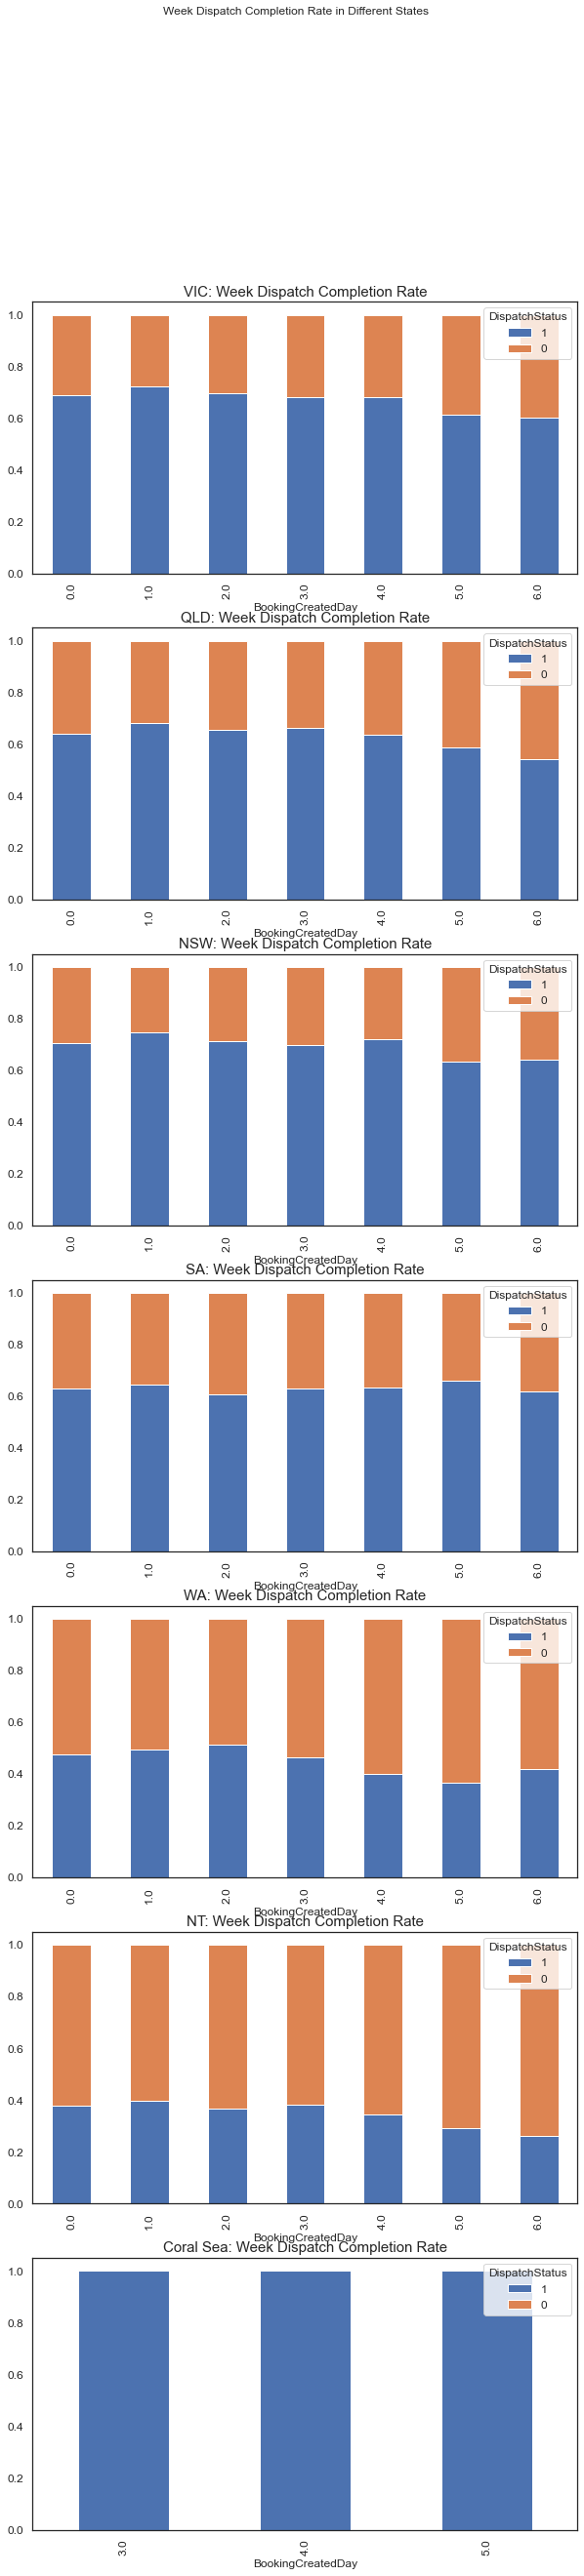

In [135]:
fig, axs=plt.subplots(7,1,figsize=(10,42))
state_list=book['StartState'].value_counts().index.to_list()
for i in range(7):
    week_state(state_list[i]).plot(kind='bar',stacked=True,ax=axs[i])
    axs[i].set_title('{}: Week Dispatch Completion Rate'.format(state_list[i]))
fig.suptitle('Week Dispatch Completion Rate in Different States')

## 暂时不知道这个是什么

In [119]:
NSW_bk=book[book['StartState']=='NSW']
# 每天的单子，颜色标注接单与否，按weekday
NSW_wk=pd.crosstab(NSW_bk['BookingCreatedDay'],NSW_bk['DispatchStatus'],normalize='index')
NSW_wk.reindex(columns=[1,0])

DispatchStatus,0.0,1.0
BookingCreatedDay,,
0.0,0.295887,0.704113
1.0,0.254029,0.745971
2.0,0.286392,0.713608
3.0,0.301233,0.698767
4.0,0.281580,0.718420
5.0,0.364917,0.635083
6.0,0.359673,0.640327


<AxesSubplot:xlabel='BookingCreatedDay'>

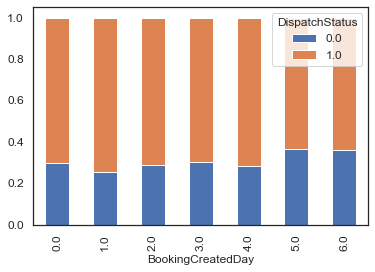

In [101]:
NSW_wk.plot(kind='bar',stacked=True)

WA和NT是唯二俩个0>1的州，是否和地理因素有关？or人口密度低有关

<AxesSubplot:xlabel='BookingCreatedHour'>

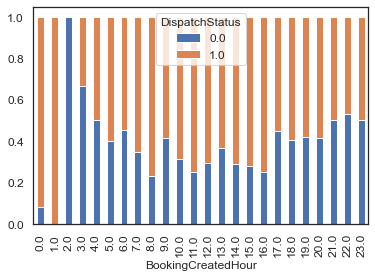

In [110]:
# 每小时的单子，颜色标注接单与否，按小时
NSW_bk=book[book['StartState']=='Coral Sea']
NSW_hr=pd.crosstab(NSW_bk['BookingCreatedHour'],NSW_bk['DispatchStatus'],normalize='index')
NSW_hr.plot(kind='bar',stacked=True)

一些可能的点：
目标是预测订单的完成率与否。因此先讨论booking的子集；lk子集脏过头了，但感觉eda中有类似的部分，可供参考

Booking：画图时完成和未完成并排显示
一些可能的点：
1. 时间
- 周一~周五打车，如果临近上班时间（8 9 10）的订单密集度（kde可看不同时间的密集）
- 可以统计费用：不同时间点的费用如何（注意这个应该看是否为州内打车-->额外加个变量，起始点和终点是否在一个州内）；比如x为时间，y为费用，颜色为是否跨州
- 时间包括星期以及每天的时间-->节假日是否算在内
- 费用的outlier是否存在？使用box看看（也可以根据时点来排列）
------
澳大利亚首都地区（ACT）：0200-0299，2600-2618，2900-2920

新南威尔士州（NSW）：1000-1999，2000-2599，2619-2899，2921-2999

北领地（NT）：0800-0899

昆士兰州（QLD）：4000-4999，9000-9999

南澳大利亚州（SA）：5000-5999，6000-6999

塔斯马尼亚州（TAS）： TAS: 7000-7999

维多利亚州（VIC）：3000-3999，8000-8999

西澳大利亚州（WA）：6000-6797，6800-6999

------
2. 地点？
- 单独把跨州的领出来看费用（上面有），以及完成率与否，如果跨州的完成率几乎很低，可以看下完成的是咋回事，如果就几个，无法解释；如果需求多，可以让公司开发跨州业务（。。。）
- 指向，这个特征工程还没做，但是要怎么做呢？
- 邮编0：澳大利亚邮政编码为四位数字，第一位代表地址所在的州，后三位以州首府城市中央邮政局为000向外递增数字，离首府城市中央邮政局越远、数字越大。因此只要看邮政编码，就能大约估量出邮政编码所在地的位置。各邮政局有全澳邮政编码手册免费检索，电话白页上也有全澳邮政编码。
- 邮编1：邮编是否可以被提取出来？比如偏远地区的接单率更低但需求估计更大（和lk集联动）因此strategy就是搞这块的业务（难点在于为什么那群人lk了但是不booking 这个是我们无法得知的）；市中心就是000，可以额外搞个变量：city（是否在市中心）同一州的邮编之差or和2000（中心）之差可以反应距离市中心有多远。
- 同样的还有机场。可以先查出来机场的比率有多高，然后创造一个机场的变量：airport（0,1变量，和上面city类似）



## 每小时+分州，成单率

### code提取（仅供参考）

In [165]:
# cs=book[book['EndState']=='Coral Sea']
# cs[cs['endCode']>='6000']
end_code=book['endCode'].unique()
np.savetxt('endcode.csv',end_code,delimiter=',', fmt='%s')
start_code=book['startCode'].unique()
np.savetxt('startcode.csv',end_code,delimiter=',', fmt='%s')

0800~0870

2000~2914

3000~3996

4000~4820

5000~5960

6000~6603

### 正常画图

In [93]:
def hour_state(state):
    state_bk=book[book['StartState']==state]
    state_hour=pd.crosstab(state_bk['BookingCreatedHour'],state_bk['DispatchStatus'],normalize='index').loc[:,1]
    state_hour=pd.DataFrame(state_hour).reset_index()
    state_hour.columns=['BookingCreatedHour','Rate']
    return state_hour

In [103]:
state_list=list(book['StartState'].unique())

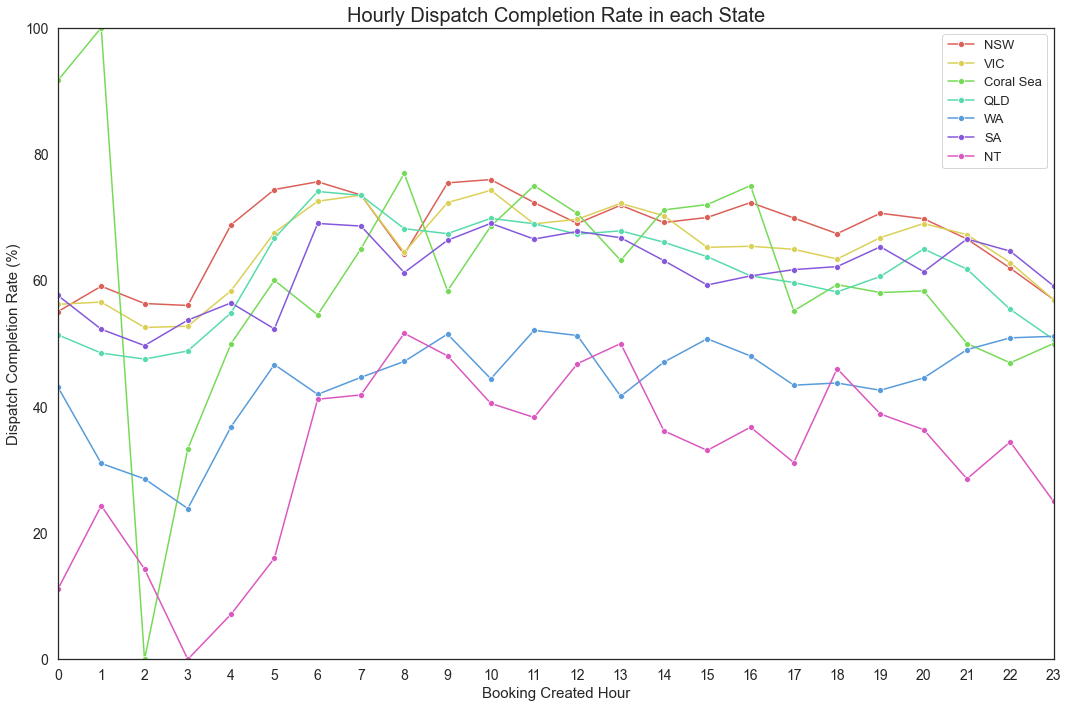

In [137]:
sns.set_palette("hls",7)
plt.figure(figsize=(15,10))
for state in state_list:
    sns.lineplot(x='BookingCreatedHour',y='Rate',data=hour_state(state),label=state,marker='o')
plt.title('Hourly Dispatch Completion Rate in each State')
plt.xlabel('Booking Created Hour')
plt.xlim(0,23)
plt.ylim(0,1)
plt.xticks(range(0,24))
plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0],[0,20,40,60,80,100])
plt.ylabel('Dispatch Completion Rate (%)')
plt.legend(loc='best')
plt.tight_layout()

In [138]:
df1 = pd.DataFrame({'x': [1, 2, 3], 'y1': [10, 20, 30]})
df2 = pd.DataFrame({'x': [1, 2, 3], 'y2': [40, 50, 60]})
pd.concat([df1, df2], axis=1)

,x,y1,x,y2
0,1,10,1,40
1,2,20,2,50
2,3,30,3,60
